In [ ]:
# default_exp modeling.token_classification

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.token_classification

> This module contains custom models, loss functions, custom splitters, etc... for token classification tasks like named entity recognition.

In [ ]:
#export
import ast

from blurr.data.all import *
from blurr.modeling.core import *

import torch
from transformers import *
from fastai2.text.all import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Token classification

The objective of token classification is to predict the correct label for each token provided in the input. In the computer vision world, this is akin to what we do in segmentation tasks whereby we attempt to predict the class/label for each pixel in an image. Named entity recognition (NER) is an example of token classification in the NLP space

In [ ]:
# germ_eval_df = pd.read_csv('./data/task-token-classification/germeval2014ner/germeval2014ner_cleaned.csv')
germ_eval_df = pd.read_csv('./germeval2014_sample.csv')

print(len(germ_eval_df))
germ_eval_df.head()

1000


,pos,token,tag1,tag2,ds_type,seq_id,n_tokens
0,1,Schartau,B-PER,O,train,1,3
1,2,sagte,O,O,train,1,1
2,3,dem,O,O,train,1,1
3,4,"""",O,O,train,1,1
4,5,Tagesspiegel,B-ORG,O,train,1,3


We are only going to be working with small sample from the [GermEval 2014](https://sites.google.com/site/germeval2014ner/data) data set ... so the results might not be all that great :)

In [ ]:
germ_eval_df.dropna(inplace=True)
germ_eval_df[germ_eval_df.token.isna()]

,pos,token,tag1,tag2,ds_type,seq_id,n_tokens


In [ ]:
labels = sorted(germ_eval_df.tag1.unique())
print(labels)

['B-LOC', 'B-LOCderiv', 'B-LOCpart', 'B-ORG', 'B-ORGpart', 'B-OTH', 'B-PER', 'B-PERpart', 'I-LOC', 'I-LOCderiv', 'I-ORG', 'I-ORGpart', 'I-OTH', 'I-PER', 'O']


In [ ]:
germ_eval_df = germ_eval_df.groupby(by='seq_id').agg(list).reset_index()
germ_eval_df.head(2)

,seq_id,pos,token,tag1,tag2,ds_type,n_tokens
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]","[Schartau, sagte, dem, "", Tagesspiegel, "", vom, Freitag, ,, Fischer, sei, "", in, einer, Weise, aufgetreten, ,, die, alles, andere, als, überzeugend, war, "", .]","[B-PER, O, O, O, B-ORG, O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train]","[3, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1]"
1,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]","[Firmengründer, Wolf, Peter, Bree, arbeitete, Anfang, der, siebziger, Jahre, als, Möbelvertreter, ,, als, er, einen, fliegenden, Händler, aus, dem, Libanon, traf, .]","[O, B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train]","[3, 1, 1, 2, 1, 1, 1, 3, 1, 1, 4, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1]"


After getting rid of troublesom NaNs and getting my labels, the code above converts my input datafame into something I can model by making the token and tag1 columns represent a list of tokens (or labels) for a give sequence.

In [ ]:
task = HF_TASKS_AUTO.ForTokenClassification
pretrained_model_name = "bert-base-multilingual-cased"
config = AutoConfig.from_pretrained(pretrained_model_name)

config.num_labels = len(labels)

Notice above how I set the `config.num_labels` attribute to the number of labels we want *our* model to be able to predict. The model will update its last layer accordingly (this concept is essentially transfer learning).

In [ ]:
hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, 
                                                                                    task=task, 
                                                                                    config=config)
hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('bert',
 transformers.tokenization_bert.BertTokenizer,
 transformers.configuration_bert.BertConfig,
 transformers.modeling_bert.BertForTokenClassification)

In [ ]:
test_eq(hf_config.num_labels, len(labels))

In [ ]:
# single input
blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['token']], 
                         hf_arch=hf_arch, 
                         hf_tokenizer=hf_tokenizer, 
                         tok_func_mode='list', 
                         task=ForTokenClassificationTask(), max_seq_len=128),
    HF_TokenCategoryBlock(vocab=labels)
)

def get_y(inp):
    return [ (label, len(hf_tokenizer.tokenize(str(entity)))) for entity, label in zip(inp.token, inp.tag1) ]

dblock = DataBlock(blocks=blocks, 
                   get_x=lambda x: x.text0,
                   get_y=get_y,
                   splitter=RandomSplitter())

We have to define a `get_y` that creates the same number of labels as there are subtokens for a particular token. For example, my name "Wayde" gets split up into two subtokens, "Way" and "##de". The label for "Wayde" is "B-PER" and we just repeat it for the subtokens.  This all get cleaned up when we show results and get predictions.

In [ ]:
dls = dblock.dataloaders(germ_eval_df, bs=4)

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category
0,"Scenes of a Sexual Nature ( GB 2006 ) - Regie : Ed Blum Shortbus ( USA 2006 ) - Regie : John Cameron Mitchell : Film über den gleichnamigen New Yorker Club, der verschiedensten Paaren eine Plattform zur Aufarbeitung ihrer Probleme bietet.","['B-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'B-OTH', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-LOCderiv', 'I-LOCderiv', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
1,Ausbildung In der Bundesrepublik Deutschland können die Befähigungszeugnisse „ Kapitän BK ( Kleine Hochseefischerei ) und „ Kapitän BG ( Große Hochseefischerei ) im Rahmen einer bundeseinheitlichen Regelung erworben werden.,"['O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0].shape

(1, torch.Size([4, 128, 15]))

In [ ]:
len(b), len(b[0]), b[0][0].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([4, 128]), 4, torch.Size([4, 128]))

In [ ]:
print(preds[0].view(-1, preds[0].shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds[0].view(-1, preds[0].shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([512, 15]) torch.Size([512])


In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=0.001096478197723627, lr_steep=1.737800812406931e-05)

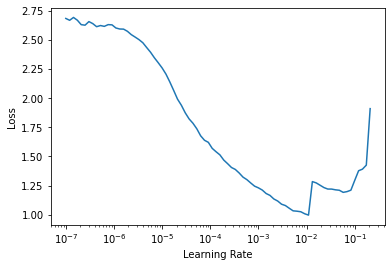

In [ ]:
#slow
learn.unfreeze()
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max= 3e-5, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,1.641890,0.369539,0.121875,00:02
1,1.016099,0.355566,0.121875,00:02
2,0.794707,0.351043,0.121875,00:02


In [ ]:
#export
@typedispatch
def show_results(x:HF_BaseInput, y:HF_TokenTensorCategory, samples, outs, hf_tokenizer, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):        
    
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
        
    samples = samples = L((TitledStr(hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')), *s[1:]) 
                          for inp, s in zip(x[0], samples))
    
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)
    for i,ctx in enumerate(ctxs): 
        preds = ast.literal_eval(outs[i][0])
        ctx['target'] = [pred for idx, pred in enumerate(preds) if (y[i][idx] != -100)]
        
    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=20)

,text,category,target
0,"Das SS - Freiwilligen - Grenadier - Regiment 88 wurde im März aus einer Kampfgruppe der SS - Führerschule des Wirtschafts - und Verwaltungsdienstes und Teilen des I. / SS - Polizei - Regiments 34 der Ordnungspolizei, Heeresangehörigen und Volkssturm gebildet.","['O', 'B-ORGpart', 'I-ORGpart', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGpart', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGpart', 'I-ORGpart', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"Der Aktienkurs blieb am Vormittag mit 63, 15 Euro nahezu konstant ( 52 - Wochen - Hoch : 64, 05 Euro ; 52 - Wochen - Tief : 49, 95 Euro ).","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OTH', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OTH', 'O', 'O', 'O', 'O', 'B-OTH', 'O', 'O']","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,""" Es wird also nicht einfach "", meint "" ManU "" - Teammanager Sir Alex Ferguson : "" Aber wir sind es gewohnt, die Ersten zu sein und müssen gewinnen.","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,Nach seinem Wechsel 1875 an das Karlsgymnasium in Bernburg ( Saale ) wurde er dort zunächst 1877 zum Oberlehrer und zehn Jahre später zum Professor ernannt.,"['O', 'O', 'O', 'O', 'O', 'O', 'B-PERpart', 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


In [ ]:
res = learn.predict('My name is Wayde and I live in San Diego')
print(res[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


The default `Learner.predict` method returns a prediction per subtoken, including the special tokens for each architecture's tokenizer.

In [ ]:
#export
@patch
def predict_tokens(self:Learner, inp, **kargs):
    """Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
    get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input
    """
    pred_lbls, pred_lbl_ids, probs = self.predict(inp)
    
    # grab the huggingface tokenizer from the learner's dls.tfms
    learn_hf_tokenizer = self.dls.tfms[0].tokenizer.filter(lambda tok: isinstance(tok, HF_Tokenizer))[0]
    hf_tokenizer = learn_hf_tokenizer.hf_tokenizer
    add_prefix_space = learn_hf_tokenizer.hf_arch in ['gpt2', 'roberta']
    
    # grab the HF_BatchTransform as well
    learn_hf_batch_transform = learn.dls.before_batch.hf__batch_transform
    
    # convert the `inp` to a list if necessary
    txt_split = inp if isinstance(inp, list) else learn_hf_tokenizer.list_split_func(inp) 

    # calculate the number of subtokens per raw/input token so that we can determine what predictions to
    # return
    subtoks_per_raw_tok = [ (entity, len(hf_tokenizer.tokenize(str(entity), add_prefix_space=add_prefix_space))) 
                           for entity in txt_split ]
    
    # very similar to what HF_BatchTransform does with the exception that we are also grabbing
    # the `special_tokens_mask` to help with getting rid or irelevant predicts for any special tokens
    # (e.g., [CLS], [SEP], etc...)
    txt_toks = [ sub_toks for entity in txt_split 
                for sub_toks in hf_tokenizer.tokenize(entity, add_prefix_space=add_prefix_space) ]
    
    txt_tok_ids = hf_tokenizer.convert_tokens_to_ids(txt_toks)
    
    res = hf_tokenizer.prepare_for_model(txt_tok_ids, None, 
                                         max_length=learn_hf_batch_transform.max_seq_len, 
                                         pad_to_max_length=True,
                                         truncation_strategy=None, 
                                         return_special_tokens_mask=True)
    
    special_toks_msk = L(res['special_tokens_mask'])
    actual_tok_idxs = special_toks_msk.argwhere(lambda el: el != 1)
    
    # using the indexes to the actual tokens, get that info from the results returned above
    pred_lbls_list = ast.literal_eval(pred_lbls)
    actual_pred_lbls = L(pred_lbls_list)[actual_tok_idxs]
    actual_pred_lbl_ids = pred_lbl_ids[actual_tok_idxs]
    actual_probs = probs[actual_tok_idxs]
    
    # now, because a raw token can be mapped to multiple subtokens, we need to build a list of indexes composed
    # of the *first* subtoken used to represent each raw token (that is where the prediction is)
    offset = 0
    raw_trg_idxs = []
    for idx, (raw_tok, sub_tok_count) in enumerate(subtoks_per_raw_tok): 
        raw_trg_idxs.append(idx+offset)
        offset += sub_tok_count-1 if (sub_tok_count > 1) else 0

    return txt_split, actual_pred_lbls[raw_trg_idxs], actual_pred_lbl_ids[raw_trg_idxs], actual_probs[raw_trg_idxs]

In [ ]:
show_doc(Learner.predict_tokens)

<h4 id="Learner.predict_tokens" class="doc_header"><code>Learner.predict_tokens</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.predict_tokens</code>(**`inp`**, **\*\*`kargs`**)

Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input

In [ ]:
txt ="Hi! My name is Wayde Gilliam from ohmeow.com."

In [ ]:
res = learn.predict_tokens(txt)
print([(tok, lbl) for tok,lbl in zip(res[0],res[1])])

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'O'), ('Gilliam', 'O'), ('from', 'O'), ('ohmeow.com.', 'O')]


It's interesting (and very cool) how well this model performs on English even thought it was trained against a German corpus.

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted index.ipynb.
